In [75]:
# Mengimpor library
import sqlite3
import pandas as pd
import seaborn as sns

# membuat file path
dbfile = 'olist.db'
# Membuat SQL connection ke SQLite database
con = sqlite3.connect(dbfile)

# Membuat cursor
cur = con.cursor()

# Menampilkan semua tabel yang terdapat pada database
table_list = [a for a in cur.execute("SELECT name FROM sqlite_master WHERE type = 'table'")]
# Menampilkan nama tabel
print(table_list)

[('olist_order_customer_dataset',), ('olist_order_dataset',), ('olist_order_reviews_dataset',), ('olist_order_payments_dataset',), ('olist_order_items_dataset',), ('olist_products_dataset',), ('olist_sellers_dataset',), ('olist_geolocation_dataset',), ('product_category_name_translation',)]


# Langkah 1 - Menentukan Objektif

Menentukan objektif permasalahan:

1. Perusahaan ingin mengetahui 10 kategori produk yang paling diminati/paling banyak diorder
2. Perusahaan ingin melihat total penjualan dari 10 kategori produk yang terbesar
3. Perusahaan menginginkan informasi pertumbuhan pemesanan produk dari 10 produk yang paling diminati

# Langkah 2 - Mengakses Dataset dan Analisa

Database yang akan diakses untuk menganalisa dan membantu menjawab objektif diatas adalah:

1. olist_order_items_dataset
2. olist_orders_dataset
3. olist_products_dataset

In [76]:
# Mengakses database olist_order_dataset dalam variabel olist_order
olist_order = pd.read_sql_query('SELECT * FROM olist_order_dataset', con)
olist_order.columns

Index(['index', 'order_id', 'customer_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date'],
      dtype='object')

In [77]:
# Mengakses database olist_order_items_dataset dalam variabel olist_order_items
olist_order_items = pd.read_sql_query('SELECT * FROM olist_order_items_dataset WHERE order_item_id > 1', con)
olist_order_items.columns

Index(['index', 'order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value'],
      dtype='object')

In [78]:
# Mengakses database olist_products_dataset dalam variabel olist_products
olist_products = pd.read_sql_query('SELECT * FROM olist_products_dataset', con)
olist_products.columns

Index(['index', 'product_id', 'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm'],
      dtype='object')

Lalu, kita menghapus kolom-kolom yang tidak diperlukan pada setiap tabel dalam analisa yakni:
    
1. olist_order_items_dataset

- seller_id
- shipping_limit_date
- index

2. olist_order_dataset

- order_status
- order_delivered_customer_date
- order_estimated_delivery_date
- order_delivered_carrier_date
- customer_id
- index

3. olist_products_dataset

- product_photos_qty
- product_weight_g
- product_length_cm
- product_height_cm
- product_width_cm
- product_description_lenght
- product_name_lenght
- index

In [79]:
# Menghapus kolom pada olist_order DataFrame
olist_order = olist_order.drop(['order_status', 'order_delivered_customer_date', 
                                'order_estimated_delivery_date', 'order_delivered_carrier_date','index',
                                'customer_id'], axis = 1)
olist_order.columns

Index(['order_id', 'order_purchase_timestamp', 'order_approved_at'], dtype='object')

In [80]:
# Menghapus kolom pada olist_order_items DataFrame
olist_order_items = olist_order_items.drop(['seller_id', 'shipping_limit_date', 'index'], axis = 1)
olist_order_items.columns

Index(['order_id', 'order_item_id', 'product_id', 'price', 'freight_value'], dtype='object')

In [81]:
# Menghapus kolom pada olist_products DataFrame
olist_products = olist_products.drop(['product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm',
                                      'product_width_cm', 'product_description_lenght', 'product_name_lenght', 'index'], axis = 1)
olist_products.columns

Index(['product_id', 'product_category_name'], dtype='object')

# Langkah 3 - Eksplorasi dan pemrosesan data

Langkah pertama, kita mencari missing value pada setiap tabel.

In [82]:
# Mengidentifikasi missing value pada olist_order DataFrame
olist_order.isna().sum().sort_values(ascending = False)

order_approved_at           160
order_id                      0
order_purchase_timestamp      0
dtype: int64

In [83]:
# Mengidentifikasi missing value pada olist_order_items DataFrame
olist_order_items.isna().sum().sort_values(ascending = False)

order_id         0
order_item_id    0
product_id       0
price            0
freight_value    0
dtype: int64

In [84]:
# Mengidentifikasi missing value pada olist_products DataFrame
olist_products.isna().sum().sort_values(ascending = False)

product_category_name    610
product_id                 0
dtype: int64

Setelah kita mendapatkan kolom mana saja yang terdapat missing value, kita akan melihat tipe data dari masing-masing kolom yang memiliki missing value tersebut

In [85]:
# Mencari informasi mengenai tipe data pada kolom di olist_order DataFrame yang terdapat missing value
olist_order['order_approved_at'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 99441 entries, 0 to 99440
Series name: order_approved_at
Non-Null Count  Dtype 
--------------  ----- 
99281 non-null  object
dtypes: object(1)
memory usage: 777.0+ KB


In [86]:
# Mencari informasi mengenai tipe data pada kolom di olist_products DataFrame yang terdapat missing value
olist_products['product_category_name'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 32951 entries, 0 to 32950
Series name: product_category_name
Non-Null Count  Dtype 
--------------  ----- 
32341 non-null  object
dtypes: object(1)
memory usage: 257.6+ KB


Lalu kita akan menggantikan missing value tersebut dengan ketentuan sebagai berikut:
    
1. missing value pada olist_order['order_approved_at'] akan di drop atau dieliminasi karena order tersebut tidak jadi dibeli atau tidak di checkout

In [87]:
# Melakukan penghapusan baris pada baris yang terdapat missing value
olist_order = olist_order.dropna(subset = ['order_approved_at'])

In [88]:
# Mengidentifikasi missing value pada olist_order DataFrame
olist_order.isna().sum().sort_values(ascending = False)

order_id                    0
order_purchase_timestamp    0
order_approved_at           0
dtype: int64

2. missing value pada olist_products['product_category_name'] akan digantikan dengan 'Unknown'

In [89]:
# Melakukan penginputan pada baris yang terdapat missing value
olist_products['product_category_name'] = olist_products['product_category_name'].fillna('unknown')

In [90]:
# Mengidentifikasi missing value pada olist_products DataFrame
olist_products.isna().sum().sort_values()

product_id               0
product_category_name    0
dtype: int64

Mencari duplikasi data yang terdapat pada ketiga dataset:

In [91]:
# Mengidentifikasi data duplikat pada olist_order DataFrame
olist_order.duplicated().sum()

0

In [92]:
# Mengidentifikasi data duplikat pada olist_products DataFrame
olist_products.duplicated().sum()

0

In [93]:
# Mengidentifikasi data duplikat pada olist_order_items DataFrame
olist_order_items.duplicated().sum()

0

Setelah mengetahui tidak adanya duplikasi dalam ketiga dataset. Lalu kita akan mengubah olist_products['product_category_name'] menjadi bahasa inggris karena hampir semua ditulis dengan bahasa portugis (inkonsisten data) menggunakan 'product_category_name_translation' dataset

In [94]:
# Menampilkan olist_products DataFrame
olist_products.head()

,product_id,product_category_name
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria
1,3aa071139cb16b67ca9e5dea641aaa2f,artes
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer
3,cef67bcfe19066a932b7673e239eb23d,bebes
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas


In [95]:
# Mengakses database product_category_name_translation dalam variabel olist_product_name
olist_product_name = pd.read_sql_query('SELECT * FROM product_category_name_translation', con)
olist_product_name

,index,product_category_name,product_category_name_english
0,0,beleza_saude,health_beauty
1,1,informatica_acessorios,computers_accessories
2,2,automotivo,auto
3,3,cama_mesa_banho,bed_bath_table
4,4,moveis_decoracao,furniture_decor
...,...,...,...
66,66,flores,flowers
67,67,artes_e_artesanato,arts_and_craftmanship
68,68,fraldas_higiene,diapers_and_hygiene
69,69,fashion_roupa_infanto_juvenil,fashion_childrens_clothes


In [96]:
# Mengukur jumlah value yang unik dari kolom product_category_name pada olist_product_name DataFrame
len(olist_product_name['product_category_name'].unique())

71

In [97]:
# Mengukur jumlah value yang unik dari kolom product_category_name pada olist_products DataFrame
len(olist_products['product_category_name'].unique())

74

In [98]:
# Menghapus kolom index pada olist_product_name DataFrame
olist_product_name = olist_product_name.drop(['index'], axis = 1)

Turns out, the product_category_name_translation is not an exhaustive dataframe. Where "portateis_cozinha_e_preparadores_de_alimentos" and "pc_gamer" are not included in the Dataframe. Therefore, explain the differences between the lenght of olist_product_name['product_category_name'] and olist_products['product_category_name'] unique value. While the other one is "unknown" which we will fill the missing value later.

We have to input both of the item into the Dataframe.	

In [99]:
# Membuat DataFrame baru untuk menambahkan value ke dalam olist_product_name DataFrame
differences = {'product_category_name': ['pc_gamer','portateis_cozinha_e_preparadores_de_alimentos'], 
               'product_category_name_english': ['pc_gamer', 'portable_kitchen_food_preparers']}
differences_item = pd.DataFrame(differences)
differences_item

,product_category_name,product_category_name_english
0,pc_gamer,pc_gamer
1,portateis_cozinha_e_preparadores_de_alimentos,portable_kitchen_food_preparers


In [100]:
# Menambahkan DataFrame baru ke dalam olist_product_name DataFrame
olist_product_name = olist_product_name.append(differences_item, ignore_index = True)

C:\Users\62821\AppData\Local\Temp\ipykernel_25568\3089567432.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  olist_product_name = olist_product_name.append(differences_item, ignore_index = True)


In [101]:
# Menampilkan olist_product_name DataFrame
olist_product_name

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor
...,...,...
68,fraldas_higiene,diapers_and_hygiene
69,fashion_roupa_infanto_juvenil,fashion_childrens_clothes
70,seguros_e_servicos,security_and_services
71,pc_gamer,pc_gamer


Setelah berhasil untuk menambahkan 2 barang ke dalam olist_product_name DataFrame lalu kita gabungkan dengan function 'merge' dengan olist_product_name (left-join) untuk mengganti inconsistent data pada olist_product_name['product_category_name']

In [102]:
# Menggabungkan olist_products DataFrame dengan olist_product_name DataFrame
olist_products = pd.merge(olist_products,olist_product_name, on = "product_category_name", how = "left")

In [103]:
# Melakukan penginputan pada baris yang terdapat missing value
olist_products['product_category_name_english'] = olist_products['product_category_name_english'].fillna('unknown')

In [104]:
# Mengidentifikasi missing value pada olist_products DataFrame
olist_products.isna().sum()

product_id                       0
product_category_name            0
product_category_name_english    0
dtype: int64

In [105]:
# Mengidentifikasi missing value pada olist_order DataFrame
olist_order.isna().sum()

order_id                    0
order_purchase_timestamp    0
order_approved_at           0
dtype: int64

In [106]:
# Mengidentifikasi missing value pada olist_order_items DataFrame
olist_order_items.isna().sum()

order_id         0
order_item_id    0
product_id       0
price            0
freight_value    0
dtype: int64

Setelah melakukan proses diatas, kita akan menggabungkan 3 DataFrame menjadi 1 dengan function 'merge' untuk melakukan analisa lebih lanjut.

In [107]:
# Menggabungkan olist_order DataFrame dengan olist_order_items DataFrame dalam join_table_temp
join_table_temp = pd.merge(olist_order,olist_order_items, on = "order_id", how = "right")

In [108]:
# Menggabungkan join_table_temp DataFrame dengan olist_products DataFrame dalam variabel join_table
join_table = pd.merge(join_table_temp,olist_products, on = "product_id", how = "left")

Ternyata setelah menggabungkan 3 DataFrame terdapat 1 item yakni telephony yang memiliki missing value pada kolom:

1. order_purchase_timestamp
2. order_approved_at

Kita akan melakukan delete dengan fungsi 'dropna' dikarenakan kedua kolom tersebut berperan penting dalam analisa yang akan dilakukan dalam studi ini

In [109]:
# Mengidentifikasi missing value pada join_table DataFrame
join_table.isna().sum().sort_values(ascending = False)

order_purchase_timestamp         1
order_approved_at                1
order_id                         0
order_item_id                    0
product_id                       0
price                            0
freight_value                    0
product_category_name            0
product_category_name_english    0
dtype: int64

In [110]:
# Melakukan penghapusan baris pada baris yang terdapat missing value
join_table = join_table.dropna(subset = ['order_approved_at'])

Untuk analisa, kita akan membutuhkan harga total dari tiap order dengan melakukan multiplication atau pengkalian antara order_item_id (order_quantity) dengan price

In [111]:
# Melakukan perkalian pada kolom order_item_id dan price, dan dijadikan kolom baru
join_table['total_transaction_value'] = join_table['order_item_id'] * join_table['price']

Sekarang, DataFrame dapat digunakan sebagai bahan untuk analisa objektif yang sudah ditentukan diatas

# Langkah 4 - Analisa

1. Perusahaan ingin mengetahui 10 kategori produk yang paling diminati/paling banyak diorder

In [112]:
# Melakukan agregasi (sum) dan groupby pada kolom product_category_name_english dan order_item_id
jumlah_pembelian_barang = join_table[["product_category_name_english", "order_item_id"]].groupby("product_category_name_english").sum().sort_values(by = "order_item_id", ascending = False).head(10)

<AxesSubplot:ylabel='product_category_name_english'>

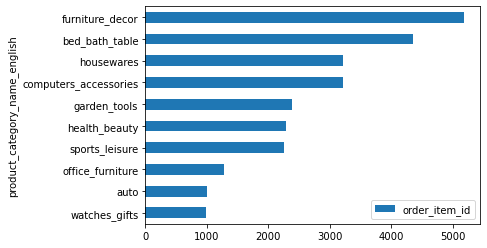

In [113]:
# Menampilkan visualisasi dengan bar chart
jumlah_pembelian_barang.sort_values(by = "order_item_id", ascending = True).plot(kind ="barh")

2. Perusahaan ingin melihat total penjualan dari 10 kategori produk yang terbesar

In [114]:
# Melakukan agregasi (sum) dan groupby pada kolom product_category_name_english dan total_transaction_value
total_penjualan_tiap_kategori_produk = join_table[["product_category_name_english","total_transaction_value"]].groupby("product_category_name_english").sum().sort_values(by = "total_transaction_value", ascending = False).head(10)

<AxesSubplot:ylabel='product_category_name_english'>

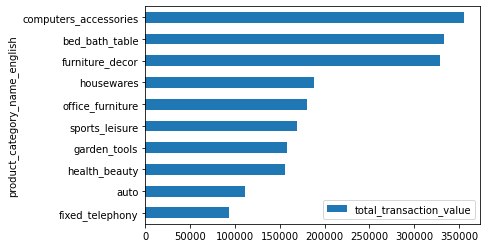

In [115]:
# Menampilkan visualisasi dengan bar chart
total_penjualan_tiap_kategori_produk.sort_values(by = "total_transaction_value", ascending = True).plot(kind ="barh")

Setelah menganalisa kedua objektif diatas, dapat diketahui bahwa kategori produk yang paling diminati/paling banyak diorder tidak selalu mendatangkan pendapatan yang paling besar. 

Dapat dilihat bahwa furniture_decor menempati pada posisi 1 sebagai produk yang paling diminati, namun menempati posisi ketiga pada total penjualan. 

Sedangkan watched_gifts yang menempati posisi 10 sebagai produk yang paling diminati, tidak termasuk dalam 10 kategori produk total penjualan terbesar.

3. Perusahaan menginginkan informasi pertumbuhan pemesanan produk dari 10 produk yang paling diminati

Sebelum melakukan analisa kita harus melihat terlebih dahulu tipe dari data order_approved_at. Jika bukan datetime, data tersebut harus diubah menjadi tipe datetime.

In [116]:
# Mengidentifikasi tipe data
join_table['order_approved_at'].info()

<class 'pandas.core.series.Series'>
Int64Index: 13983 entries, 0 to 13983
Series name: order_approved_at
Non-Null Count  Dtype 
--------------  ----- 
13983 non-null  object
dtypes: object(1)
memory usage: 218.5+ KB


Ternyata, data order_approved_at masih bertipe object sehingga harus di ubah menjadi tipe data datetime

In [117]:
# Melakukan slicing pada DataFrame untuk menampilkan beberapa kolom dan dimasukan ke dalam pertumbuhan_pemesanan
pertumbuhan_pemesanan = join_table[['order_approved_at','product_category_name_english', 'order_item_id']]

In [118]:
# Melakukan transformasi tipe data ke tipe date_time
pertumbuhan_pemesanan['order_approved_at'] = pd.to_datetime(pertumbuhan_pemesanan['order_approved_at'])

C:\Users\62821\AppData\Local\Temp\ipykernel_25568\2959739886.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pertumbuhan_pemesanan['order_approved_at'] = pd.to_datetime(pertumbuhan_pemesanan['order_approved_at'])


In [119]:
# Melakukan transformasi tipe data ke tipe date_time dan dimasukan ke dalam kolom baru 'year'
pertumbuhan_pemesanan['year'] = pertumbuhan_pemesanan['order_approved_at'].dt.year

C:\Users\62821\AppData\Local\Temp\ipykernel_25568\3782634273.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pertumbuhan_pemesanan['year'] = pertumbuhan_pemesanan['order_approved_at'].dt.year


In [120]:
# Menampilkan pertumbuhan_pemesanan DataFrame
pertumbuhan_pemesanan

,order_approved_at,product_category_name_english,order_item_id,year
0,2018-02-15 03:55:52,garden_tools,2,2018
1,2017-10-16 16:07:52,sports_leisure,2,2017
2,2017-10-16 16:07:52,sports_leisure,3,2017
3,2017-12-28 02:33:42,electronics,2,2017
4,2017-12-28 02:33:42,electronics,3,2017
...,...,...,...,...
13979,2018-02-27 20:15:27,electronics,3,2018
13980,2018-03-17 12:29:22,computers_accessories,2,2018
13981,2017-10-28 02:55:58,watches_gifts,2,2017
13982,2017-10-28 02:55:58,watches_gifts,3,2017


In [121]:
# Membuat pivot table dan dimasukan ke dalam pertumbuhan_pemesanan_barang
pertumbuhan_pemesanan_barang = pertumbuhan_pemesanan.pivot_table(values = "order_item_id", index = ["year"], columns = ["product_category_name_english"],aggfunc = "sum", margins = True, margins_name = "Total", fill_value = 0)

In [122]:
# Melakukan transpose pada pivot table
pertumbuhan_pemesanan_barang = pertumbuhan_pemesanan_barang.T

In [123]:
jumlah_pembelian_barang

,order_item_id
product_category_name_english,
furniture_decor,5185
bed_bath_table,4354
housewares,3222
computers_accessories,3214
garden_tools,2392
health_beauty,2285
sports_leisure,2251
office_furniture,1273
auto,1001


In [124]:
# Melakukan sorting descending pada pivot table
pertumbuhan_barang_10_terbesar = pertumbuhan_pemesanan_barang[:-1].sort_values(by = "Total", ascending = False).head(10)

In [125]:
pertumbuhan_barang_10_terbesar

year,2016,2017,2018,Total
product_category_name_english,,,,
furniture_decor,54,2623,2508,5185
bed_bath_table,11,1853,2490,4354
housewares,7,1288,1927,3222
computers_accessories,9,1310,1895,3214
garden_tools,0,1399,993,2392
health_beauty,15,860,1410,2285
sports_leisure,0,1106,1145,2251
office_furniture,0,542,731,1273
auto,2,605,394,1001


<AxesSubplot:ylabel='product_category_name_english'>

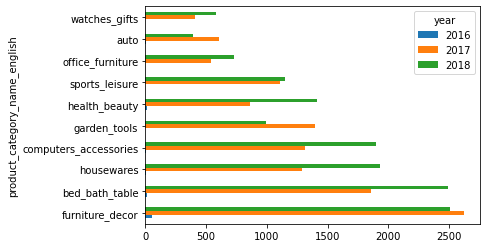

In [126]:
# Menampilkan visualisasi dengan bar chart
pertumbuhan_barang_10_terbesar.iloc[:,0:3].plot(kind = "barh")

Terlihat dari bar plot di atas, ternyata pertumbuhan kategori produk yang paling pesat terlihat pada kategori produk bed_bath_table. Hal ini cukup membuktikan bahwa produk bed_bath_table merupakan produk paling bagus performanya dibandingkan dengan produk lain. 

Sedangkan, performa produk garden_tools perlu diperhatikan dikarenakan menurun secara signifikan dari 1399 menjadi 993 (turun sebesar 29 persen). Perusahaan perlu mencari penyebab penurunan signifikan pada produk garden_tools.